In [1]:
#pip install tensorflow_hub
#pip install tensorflow-gpu==2.10.0
#pip install keras
#pip install tensorflow-text
#!pip install keras-tuner --upgrade

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # text vectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax,Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFDistilBertModel, DistilBertTokenizer,TFT5Model,T5Tokenizer
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import time
from sklearn.metrics import (mean_squared_error, r2_score, f1_score, roc_auc_score, mean_absolute_error)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.model_selection import cross_val_score


In [3]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow Sürümü:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Sürümü: 2.10.1


In [4]:
data=pd.read_csv('Truth_Seeker.csv')

In [5]:
data['BinaryNumTarget'] = data['BinaryNumTarget'].astype(int)

In [6]:
data.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [7]:
data.rename( columns={'Unnamed: 0':'index'}, inplace=True )
data.drop('index',axis=1,inplace=True)

<Axes: xlabel='BinaryNumTarget', ylabel='count'>

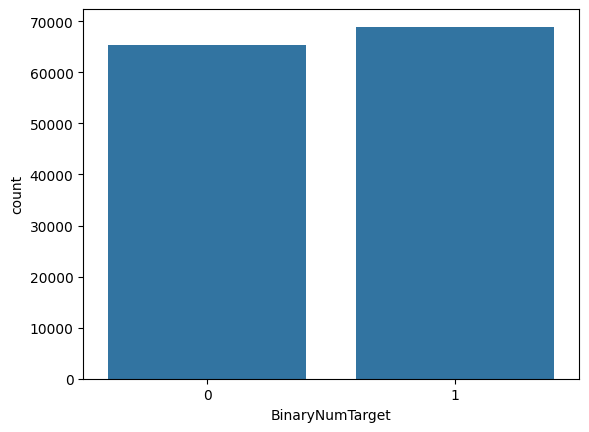

In [8]:
sns.countplot(x='BinaryNumTarget',data=data) # our outputs

In [9]:
x=data.tweet
y=data.BinaryNumTarget
cols_to_remove=['author','target','BinaryNumTarget','manual_keywords']
data.drop(cols_to_remove,inplace=True,axis=1)

In [10]:
data[data.duplicated()].sum()

statement                  0
tweet                      0
5_label_majority_answer    0
3_label_majority_answer    0
dtype: object

Text Cleaning Section

In [11]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

def _remove_emails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', "", x)

def _remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)

def _remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def _remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

def _remove_html_tags(x):
    return re.sub(r'<.*?>', '', x)

def _remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

def _remove_mentions(x):
    return ' '.join([word for word in x.split() if not word.startswith('@')])

def _remove_hashtags(x):
    return ' '.join([word for word in x.split() if not word.startswith('#')])

def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    else:
        return x

def preprocessingText(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('-', ' ')
    x = _remove_stopwords(x)
    x = _remove_emails(x)
    x = _remove_urls(x)
    x = _remove_html_tags(x)
    x = _remove_rt(x)
    x = _remove_mentions(x)
    x = _remove_hashtags(x)
    x = cont_to_exp(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    
    return x

In [12]:
pd.set_option('display.max_colwidth', 500)
print(x)

0                          @POTUS Biden Blunders - 6 Month Update\n\nInflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?
1         @S0SickRick @Stairmaster_ @6d6f636869 Not as many people are literally starving and out in the streets as they were in the 19th century. Isnt capitalism grand?\n\nMeanwhile, were facing an eviction moratorium threatening to make millions of Americans homeless.\n\nFuck off with this corporatist propaganda.
2                                                                                              THE SUPREME COURT is siding with super rich property owners and over poor struggling AMERICANS by blocking the eviction moratorium during a pandemic which isn't even over yet. ASSHOLES! get ready for more homeless people!
3                           @POTUS Biden Blunders

In [13]:
pd.set_option('display.max_colwidth', 500)
x = x.apply(lambda x: preprocessingText(x))   
print(x)

0                      biden blunders 6 month update inflation, delta mismanagement, covid kids, abandoning americans afghanistan, arming taliban, s. border crisis, breaking job growth, abuse power (many exec orders, $3.5t reconciliation, eviction moratorium).what miss?
1                                                                                           people literally starving streets 19th century. isnt capitalism grand? meanwhile, facing eviction moratorium threatening millions americans homeless. fuck corporatist propaganda.
2                                                                                                                 supreme court siding super rich property owners poor struggling americans blocking eviction moratorium pandemic is not yet. assholes! ready homeless people!
3         biden blunders broken campaign promises, inflation, delta mismanagement, dems leadership, abandoned americans &amp; armed taliban, s. border crisis, breaking job growth, abuse p

Machine Learning Section

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000)

feature_vec = vectorizer.fit_transform(x)

TFIDF Implementation

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(feature_vec)
X_train_tf = tf_transformer.transform(feature_vec)

TomekLinks Implementation in order to prevent misclassification and get more balanced data

In [16]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tl, y_tl= tl.fit_resample(X_train_tf, y)
print(y_tl.value_counts())

BinaryNumTarget
1    68876
0    65268
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_tl, y_tl, train_size=0.8, test_size=0.2,stratify=y_tl)

y_test.value_counts()

BinaryNumTarget
1    13775
0    13054
Name: count, dtype: int64

In [18]:
classification_models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    ExtraTreeClassifier(random_state=42),
    XGBClassifier(random_state=42),
    XGBRFClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    SGDClassifier(random_state=42),
    SVC(random_state=42)]

def evaluate_classification_models(x_train, x_test, y_train, y_test, models):
    
    model_results = []
    trained_models = {}
    for model in models:
        model.fit(x_train, y_train)
        trained_models[model.__class__.__name__] = model  # Save trained model with name
        start_time = time.time()  # Record start time
        prediction = model.predict(x_test)
        inference_time = time.time() - start_time  # Calculate inference time

        model_results.append({
            "Model-Name": model.__class__.__name__,
            "Accuracy": accuracy_score(y_test, prediction) * 100,
            "ROC_AUC": roc_auc_score(y_test, prediction),
            "F1_Score": f1_score(y_test, prediction),
            "Precision": precision_score(y_test, prediction),
            "Recall": recall_score(y_test, prediction),
            "Inference Time (ms)": inference_time * 1000
        })

    models_df = pd.DataFrame(model_results)
    models_df = models_df.set_index('Model-Name')
    models_df = models_df.sort_values("F1_Score", ascending=False)
    return models_df, trained_models


In [19]:
models_df, trained_models = evaluate_classification_models(x_train, x_test, y_train, y_test, classification_models)

C:\Users\TAN\AppData\Local\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [20]:
models_df

,Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,
SVC,98.945171,0.989455,0.989724,0.990119,0.989328,82989.593744
ExtraTreesClassifier,98.863170,0.988649,0.988919,0.989818,0.988022,1162.738085
RandomForestClassifier,98.315256,0.983191,0.983564,0.985355,0.981779,1046.897888
BaggingClassifier,97.767341,0.977696,0.978227,0.979616,0.976842,192.410946
LogisticRegression,97.457975,0.974553,0.975252,0.974969,0.975535,1.502752
DecisionTreeClassifier,97.279064,0.972747,0.973526,0.972679,0.974374,31.757116
SGDClassifier,97.133699,0.971247,0.972157,0.969734,0.974592,10.192394
XGBClassifier,96.268963,0.962183,0.964287,0.948085,0.981053,11.723280
ExtraTreeClassifier,92.064557,0.920681,0.922461,0.925596,0.919347,10.730982


In [21]:
def evaluate_classification_metrics(y_true, y_pred, target_names=None, display=True):   
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
  
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(y_true, y_pred, target_names=target_names)

    if display:
        ConfusionMatrixDisplay(cm, display_labels=target_names).plot()
        plt.show()

    evaluation_results = {
        "Confusion Matrix": cm,
        "Classification Report": report,
        "Target Names": target_names,
    }
    return evaluation_results

In [22]:
prediction = trained_models["SVC"].predict(x_test)

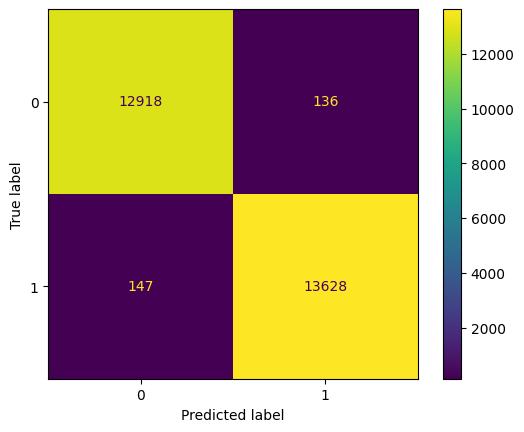

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
target_names = ["0", "1"]
evaluation = evaluate_classification_metrics(y_test, prediction,target_names)

Transformer Model Section

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y,train_size=0.8,random_state=42,shuffle=True)

In [25]:
y_train.value_counts()

BinaryNumTarget
1    55166
0    52192
Name: count, dtype: int64

In [26]:
#!pip install datasets transformers[sentencepiece]
#!pip install sentencepiece

In [27]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", local_files_only=True)
transformer = TFDistilBertModel.from_pretrained("distilbert-base-uncased", local_files_only=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [28]:
max_len = 160

def bert_encode(tokenizer, data):
    return data.apply(lambda tweet: tokenizer.encode(tweet, add_special_tokens=True))

def max_len_sequences(sequences):
    max_len = 0
    
    for sequence in sequences:
        if len(sequence) > max_len:
            max_len = len(sequence)
    return max_len

def pad_sequences(sequences, max_len):
    return np.array([sequence + [0] * (max_len - len(sequence))
                    for sequence in sequences])

In [29]:
sequences = bert_encode(tokenizer, X_train)
sequences_test = bert_encode(tokenizer, X_test)

In [30]:
sequences = pad_sequences(sequences, max_len)           # for X_train
sequences_test = pad_sequences(sequences_test, max_len) # for X_test

In [31]:
from tensorflow.keras.layers import Dense, Input,Dropout,LSTM,Embedding,Bidirectional
from tensorflow.keras.layers import Reshape
EarlyStoppingCallBack = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)  # EarlyStopping callback initilization depends on val_accuracy
from keras_tuner.tuners import GridSearch
from tensorflow.keras.optimizers import Adam, RMSprop,SGD,Adadelta,Adagrad,Adamax,Nadam,Ftrl
histories = {}
def build_model(hp):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    for i in range(hp.Int("mlp_layers", 1, 5)):
        cls_token =Bidirectional(LSTM(hp.Choice('lstm_unit', values=[128,256]), return_sequences=True))(Reshape((1, -1))(cls_token))
        cls_token =Bidirectional(LSTM(64))(cls_token)
        cls_token = tf.keras.layers.Dense(
        units=hp.Int(f"units_{i}", 32, 256, step=32),
        activation=hp.Choice(f"activation_{i}", ["relu", "tanh","gelu"]),
        kernel_initializer=hp.Choice(f"kernel_initializer_{i}", ['uniform']))(cls_token)
        if hp.Boolean(f"ann_dropout_{i}" ):
            cls_token=tf.keras.layers.Dropout(0.10)(cls_token)
        if hp.Boolean("dropout_layer"):
            cls_token = tf.keras.layers.Dropout(0.10)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)

    
    #Definining and choosing optimizers
    optimizer_names = hp.Choice('optimizer', values=['Adam', 'SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam'])

    # Choosing learning rates
    learning_rate_choice = hp.Choice('learning_rate', values=[1e-5,1e-6])
   
    if optimizer_names == 'Adam':
        optimizer = Adam(learning_rate=learning_rate_choice)
    elif optimizer_names == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate_choice)
    elif optimizer_names == 'SGD':
        optimizer = SGD(learning_rate=learning_rate_choice)
    elif optimizer_names == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate_choice)
    elif optimizer_names == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate_choice)
    elif optimizer_names == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate_choice)
    elif optimizer_names == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate_choice)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = GridSearch(build_model,objective='accuracy',max_trials=25,executions_per_trial=2,directory='/logs/Log',project_name="/logs/Log")
tuner.search(sequences, y_train, validation_data=(sequences_test,y_test),callbacks=[tf.keras.callbacks.TensorBoard("/logs/tb_logs")])
tuner.results_summary()

Trial 25 Complete [00h 35m 05s]
accuracy: 0.9990778565406799

Best accuracy So Far: 0.9990778565406799
Total elapsed time: 14h 49m 41s
Results summary
Results in /logs/Log
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 24 summary
Hyperparameters:
mlp_layers: 1
lstm_unit: 128
units_0: 32
activation_0: relu
kernel_initializer_0: uniform
ann_dropout_0: False
dropout_layer: True
optimizer: Adamax
learning_rate: 1e-05
Score: 0.9990778565406799

Trial 18 summary
Hyperparameters:
mlp_layers: 1
lstm_unit: 128
units_0: 32
activation_0: relu
kernel_initializer_0: uniform
ann_dropout_0: False
dropout_layer: True
optimizer: RMSprop
learning_rate: 1e-05
Score: 0.9986773133277893

Trial 19 summary
Hyperparameters:
mlp_layers: 1
lstm_unit: 128
units_0: 32
activation_0: relu
kernel_initializer_0: uniform
ann_dropout_0: False
dropout_layer: True
optimizer: RMSprop
learning_rate: 1e-06
Score: 0.9983652830123901

Trial 13 summary
Hyperparameters:
mlp_layers: 1
lstm_unit: 128
un

In [32]:
best_model = tuner.get_best_models(num_models=1)[0]

In [33]:
history=best_model.fit(sequences, y_train, validation_data=(sequences_test,y_test), epochs=10, batch_size=32,verbose=1)

Epoch 1/10
3355/3355 [==============================] - 1046s 310ms/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.0392 - val_accuracy: 0.9932
Epoch 2/10
3355/3355 [==============================] - 1040s 310ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.0332 - val_accuracy: 0.9938
Epoch 3/10
3355/3355 [==============================] - 1041s 310ms/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0343 - val_accuracy: 0.9937
Epoch 4/10
3355/3355 [==============================] - 1040s 310ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.0360 - val_accuracy: 0.9933
Epoch 5/10
3355/3355 [==============================] - 1048s 312ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.0342 - val_accuracy: 0.9931
Epoch 6/10
3355/3355 [==============================] - 1059s 316ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0369 - val_accuracy: 0.9941
Epoch 7/10
3355/3355 [==============================] - 1070s 319ms/step - loss: 0.0043 - accuracy: 0.9995

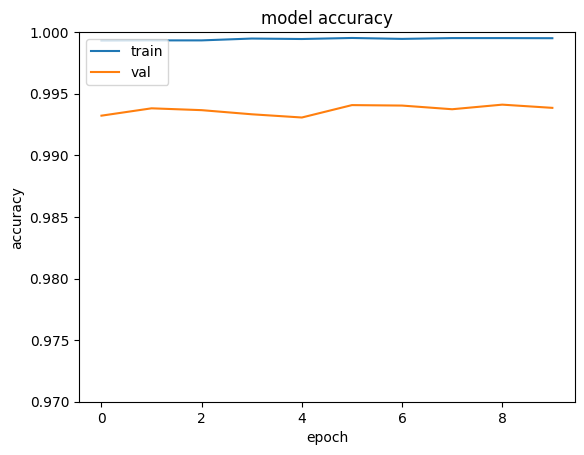

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0.97, 1)  # Y eksenini 0 ile 1 arasında sınırla
plt.show()

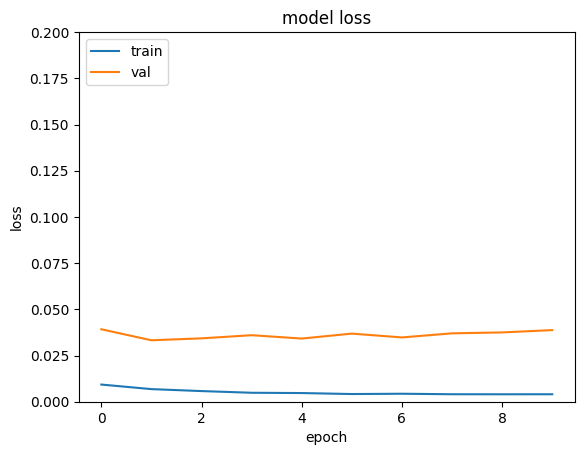

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0, 0.2)  # Y eksenini 0 ile 1 arasında sınırla
plt.show()

In [36]:
y_predicted = best_model.predict(sequences_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

839/839 [==============================] - 81s 94ms/step


In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

Text(50.722222222222214, 0.5, 'Truth')

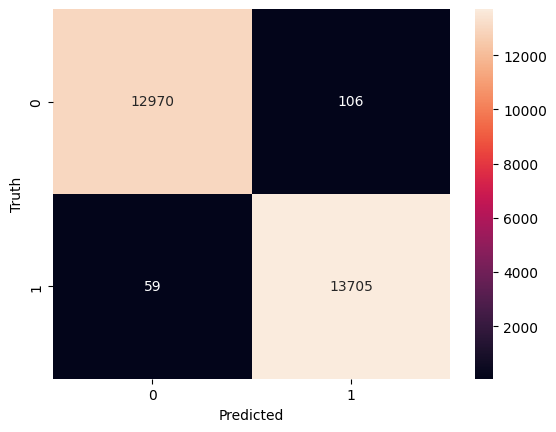

In [38]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13076
           1       0.99      1.00      0.99     13764

    accuracy                           0.99     26840
   macro avg       0.99      0.99      0.99     26840
weighted avg       0.99      0.99      0.99     26840

